# SMAI Assignment - 2

## Question 3: Face Recognition using Principal Component Analysis

This question requires you to create a basic facial recognition system using a technique called principal component analysis (PCA) by projecting the face images on the feature space (face space) which best
represents the variations among distinct faces. The face space is defined as the
“Eigenfaces", which are the eigenvectors of the set of faces.

The goal of implementing this system is to recognize a person's face by comparing it to a pre-existing database of faces, and identifying the closest match.

Link to paper on Eigenfaces: [https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf](https://sites.cs.ucsb.edu/~mturk/Papers/mturk-CVPR91.pdf)

The AT&T face dataset contains a set of grayscale face images with dimensions 92x112. The images are organised in 40 directories (one for each subject), which have names of the form sX, where X indicates the subject number (between 1 and 40). In each of these directories, there are ten different images of that subject, which have names of the form Y.pgm, where Y is the image number for that subject (between 1 and 10). These 10 images per person are taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). <b>Link:</b> [https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/)

#### Tasks
1. Load dataset and divide the date into training and test sets. 
2. Implement the PCA algorithm from scratch.
3. Implement image reconstruction using the eigen projections and visualise differences for different number of components.
4. Visualise the mean(Eigen face) generated.
5. Given training set, obtain accuracy by attempting a face regonition module and obtaining the accuracy for different number of principal components.

#### Import Libraries

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import cv2
from copy import copy
from tqdm import tqdm

In [45]:
w=[[1,2,3],[4,5,6],[7,8,9]]
v=[[1,2,3],[4,5,6],[7,8,9]]
v_t=np.transpose(v)
print("v_t",v_t)
c=np.dot(w,v)
print("c",c)

v_t [[1 4 7]
 [2 5 8]
 [3 6 9]]
c [[ 30  36  42]
 [ 66  81  96]
 [102 126 150]]


In [46]:
import numpy as np

sample_array = np.array([[1, 2, 3], [3, 4, 5]])
print("Sample array:", sample_array.shape)
mean = np.mean(sample_array, axis=0)
print("Mean:", mean)
final_array=sample_array-mean
print("final_array:", final_array)


Sample array: (2, 3)
Mean: [2. 3. 4.]
final_array: [[-1. -1. -1.]
 [ 1.  1.  1.]]


In [47]:
import numpy as np

# Normalize the array
array = np.array([1, 2, 3])
normalized_array = array / np.linalg.norm(array)
print("Normalized array:", normalized_array)

# Sample matrix
sample_matrix = np.array([[-2, -4, 2], [-2, 1, 2], [4, 2, 5]])
print("Sample matrix:", sample_matrix)

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(sample_matrix)

print("eigen_vectors",eigenvectors)

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Select the top 2 eigenvectors
top_eigenvectors = sorted_eigenvectors[:, :2]

# Print the top 2 eigenvalues and eigenvectors
print("Top 2 eigenvalues:", sorted_eigenvalues[:2])
print("Top 2 eigenvectors:\n", top_eigenvectors)

# dot profuct of two matruxs
a = np.array([[1, 2], [3, 4]])
b = np.array([[5, 6], [7, 8]])
c = np.dot(a, b)
print("Dot product of a and b:", c)


Normalized array: [0.26726124 0.53452248 0.80178373]
Sample matrix: [[-2 -4  2]
 [-2  1  2]
 [ 4  2  5]]
eigen_vectors [[ 0.81649658  0.53452248  0.05842062]
 [ 0.40824829 -0.80178373  0.35052374]
 [-0.40824829 -0.26726124  0.93472998]]
Top 2 eigenvalues: [6. 3.]
Top 2 eigenvectors:
 [[ 0.05842062  0.53452248]
 [ 0.35052374 -0.80178373]
 [ 0.93472998 -0.26726124]]
Dot product of a and b: [[19 22]
 [43 50]]


#### Import Dataset
Assign labels for the images based on the subdirectories to obtain X(images array) and y (labels).

Ensure that the test data contains atleast one image from each category.

In [48]:
# iterate through all folders, load each image

trainAmt = 0.9
allFaces = []
labels = []

for i in range(1,41):
    for j in range(1,11):
        imgPath = os.path.join("ATnT", "s" + str(i), str(j) + ".pgm")
        img = cv2.imread(imgPath, -1)

        allFaces.append(img)
        labels.append(i)

# shuffle
randomOrder = np.random.permutation(len(labels))
allFaces = np.array(allFaces)[randomOrder]
labels = np.array(labels)[randomOrder]

# split
trainFaces = allFaces[:int(trainAmt*len(allFaces))]
trainLabels = labels[:int(trainAmt*len(allFaces))]

testFaces = allFaces[int(trainAmt*len(allFaces)): ]
testLabels = labels[int(trainAmt*len(allFaces)): ]

# 112x92 (= 10304) grayscale images,  360 in train, 40 in test
print(trainFaces.shape, trainLabels.shape)

(360, 112, 92) (360,)


In [49]:
trainFaces = np.array(trainFaces)
trainFaces = trainFaces.reshape((trainFaces.shape[0], 112, 92))

trainfaces are basically total 360 images each of size 112*92. TrainLabels correspond to the labels of the images.

#### Implement PCA Algorithm.

Explain your steps with comments and write a brief explanation of the method.

In [50]:
numComponents = 20

In [51]:
def principalComponentAnalysis(X, numComponents):
    """
    Implement pca in the following function by taking the following arguements:
    1. X(images array)
    2. number of components
    The function must return the eigen vectors (principal components) also termed "Eigen faces"
    """
    # STEP 1 : RESPRESENT IMAGES USING VECTOR 
    flattened_trainFaces=[]
    print("total images",trainFaces.shape[0]) #360
    for i in range(trainFaces.shape[0]):
        flattened_trainFaces.append(trainFaces[i].flatten())
    flattened_trainFaces = np.array(flattened_trainFaces)
    print("flattened_trainFaces shape",flattened_trainFaces.shape)

    # STEP 2: COMPUTE THE MEAN FACE
    mean_face = np.mean(flattened_trainFaces, axis=0)
    print("mean_face_shape",mean_face.shape)

    # print mean face as 5*5
    zero_mean_faces_resize = mean_face.reshape((112, 92))
    plt.imshow(zero_mean_faces_resize, cmap='gray')
    plt.axis('off')

    zero_mean_faces = flattened_trainFaces - mean_face
    print("zero_mean_faces shape",zero_mean_faces.shape)

    # plot zero mean faces just to visulise in 2*5 grid
    zero_mean_faces_resize = zero_mean_faces.reshape((zero_mean_faces.shape[0], 112, 92))
    for i in range(10):
        # show them as grid of 2x5
        plt.subplot(2, 5, i+1)
        plt.imshow(zero_mean_faces_resize[i], cmap='gray')
        plt.axis('off')
    
    # STEP 3 : GETTING COVARIANCE MATRIX
    C = np.dot(np.transpose(zero_mean_faces), zero_mean_faces)

    # STEP 4 :FIND EIGEN VALUES AND EIGEN VECTOR and take top numComponents
    eigen_values, eigen_vectors = np.linalg.eigh(C)
    return eigen_values,eigen_vectors, mean_face, zero_mean_faces

total images 360
flattened_trainFaces shape (360, 10304)
mean_face_shape (10304,)
zero_mean_faces shape (360, 10304)


C:\Users\anshu\AppData\Local\Temp\ipykernel_3916\1353730759.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 5, i+1)


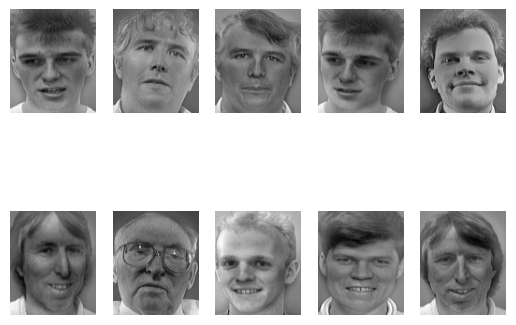

In [52]:
eigen_values,eigen_faces, mean_face, zero_mean_faces = principalComponentAnalysis(trainFaces,numComponents)

In [53]:
sorted_indices = np.argsort(eigen_values)[::-1]
eigen_faces = eigen_faces[:, sorted_indices]
print("eigen_faces shape",eigen_faces.shape)


eigen_faces shape (10304, 10304)


#### Implement Image Reconstruction from Eigenfaces


Explain your steps with comments and write a brief explanation of the method.

In [54]:
def imageReconstruction(testFace, eigenFaces, meanFace,numComponents):
    """
    Helper function to reconstruct images
    """
    # STEP 1 : flatten the test face
    flattened_testFace = testFace.flatten()
    print("flattened_testFace shape",flattened_testFace.shape)

    # STEP 2 SUBTRACT THE MEAN FACE
    zero_mean_testFace = flattened_testFace - meanFace
    print("zero_mean_testFace shape",zero_mean_testFace.shape)

    # STEP 3 : COMPUTE WEIGHTS
    weights = np.dot(zero_mean_testFace, eigenFaces)
    print("weights shape",weights.shape)

    # STEP 4 : RECONSTRUCT THE FACES Ir= meanface + eigen faces*weights

    weights_reshaped = weights.reshape(1, numComponents, 1)
    result = np.sum(weights_reshaped * eigenFaces.T, axis=1)
    print("result shape",result.shape)
    reconstrcuted_faces = result + meanFace

    reconstrcuted_faces_resize = reconstrcuted_faces.reshape((reconstrcuted_faces.shape[0], 112, 92))
    # plot it for better visulisation

    # plt.imshow(reconstrcuted_faces_resize[0], cmap='gray')
    # plt.axis('off')
    return reconstrcuted_faces_resize,weights

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)


(-0.5, 91.5, 111.5, -0.5)

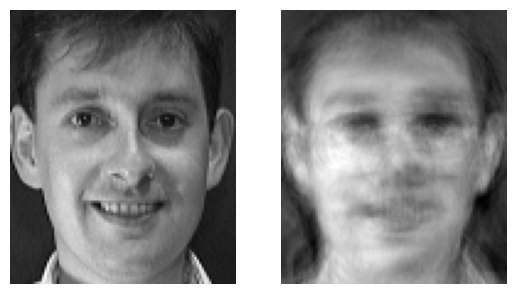

In [62]:
# lets plot test face zero so it better visulize
# plt.imshow(testFaces[0], cmap='gray')
numComponents=50
eigen_faces2=eigen_faces[:, :numComponents]
recons_face,weight=imageReconstruction(testFaces[0], eigen_faces2, mean_face,numComponents)

# plot the original face and reconstructed face

plt.subplot(1, 2, 1)
plt.imshow(testFaces[0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(recons_face[0], cmap='gray')
plt.axis('off')

In order to find the accuracy, what can be done is, if you have overall weights for all the images in the weights array (360*100) and the weight of the test image in the weights array is (1*100), you can find the difference between the weights of the test image and all the images. Then, locate the minimum difference, and the label of that image is the label of the test image. To verify, you should have the label of the test image, which you can use for accuracy calculation. Loop through all test images, call the reconstruction function, and find the accuracy.



In [80]:
# we need the weights from the training data 

def weights_train(zero_mean_faces, eigen_faces, mean_face,numComponents):
    # STEP 5 : COMPUTE WEIGHTS
    weights = np.dot(zero_mean_faces, eigen_faces)
    print("weights shape",weights.shape)
    return weights

eigen_faces_w=eigen_faces[:, :numComponents]
weights=weights_train(zero_mean_faces, eigen_faces_w, mean_face,numComponents)



weights shape (360, 50)


In [81]:
import numpy as np

def accuracy(testFaces, eigenFaces, meanFace, trainWeights, trainLabels, testLabels,numComponents):
    """
    Implement the accuracy function which will return the accuracy.
    """
    correct = 0
    differences_dict = {}

    for i in range(testFaces.shape[0]):
        recons_face, weight = imageReconstruction(testFaces[i], eigenFaces, meanFace, numComponents)
        
        # Find difference from actual image
        difference = testFaces[i].flatten() - recons_face.flatten()
        squared_difference = np.sum(np.square(difference))  # Squared difference
        
        differences_dict[i] = squared_difference
        
        # Calculate distance between test image and all train images
        distance = np.linalg.norm(trainWeights - weight, axis=1)
        
        # Find the index of minimum distance
        min_index = np.argmin(distance)
        
        # Check if the label of the test image is the same as the train image
        if trainLabels[min_index] == testLabels[i]:
            correct += 1
    
    accuracy = correct / testFaces.shape[0]
    return accuracy, differences_dict


In [82]:
eigen_faces3=eigen_faces[:, :numComponents]
accuracy_test=accuracy(testFaces, eigen_faces3, mean_face, weights, trainLabels,testLabels,numComponents)
print("accuracy_test",accuracy_test)

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (50,)
result shape (1,

In [83]:
print("accuracy_test",accuracy_test[0])

accuracy_test 1.0


In [79]:
# plot recontructions here
%matplotlib inline

#### Visualisation
Visualise the results for different number of factors(pc = 5, 10, 50, 100, etc.)

**Note:** Ensure that the images are labelled appropriately.

In [84]:
print(eigen_faces.shape)
eigen_faces_4=eigen_faces[:, :numComponents]
print(eigen_faces_4.shape)

(10304, 10304)
(10304, 50)


In [85]:
import matplotlib.pyplot as plt

def displayNfactors(testFaces, eigenFaces, meanFace, trainWeights, trainLabels, testLabels, num_components_list):
    # we store the difference between the original and reconstructed images for differnt num compoennt for final plo
    differences=[]
    for num_components in num_components_list:
        # Perform reconstruction with the specified number of components
        difference=0
        reconstructed_faces = []

        for i in range(testFaces.shape[0]):
            recons_face, _ = imageReconstruction(testFaces[i], eigenFaces[:, :num_components], meanFace, num_components)
            recons_face_f=recons_face.flatten()
            difference+=np.sum(np.square(testFaces[i].flatten() - recons_face_f))
            recons_face = recons_face.reshape((112, 92))
            reconstructed_faces.append(recons_face)

        # Display reconstructed test faces
        plt.figure(figsize=(12, 4))
        for i in range(3):  # Displaying three test faces
            plt.subplot(2, 3, i + 1)
            plt.imshow(testFaces[i], cmap='gray')
            plt.axis('off')
            plt.title(f'Test Face {i + 1}')

            plt.subplot(2, 3, i + 4)

            plt.imshow(reconstructed_faces[i], cmap='gray')
            plt.axis('off')
            plt.title(f'Reconstructed Face (Components={num_components})')

        plt.tight_layout()
        plt.show()
        differences.append(difference)
    
    # Plot the difference between the original and reconstructed images
     # Plot the difference between the original and reconstructed images
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(num_components_list)), differences, tick_label=num_components_list)
    plt.xlabel('Number of Components')
    plt.ylabel('Difference')
    plt.title('Difference between Original and Reconstructed Images')
    plt.show()
        


flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (5,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (5,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (5,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (5,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (5,)
result shape (1, 10304)


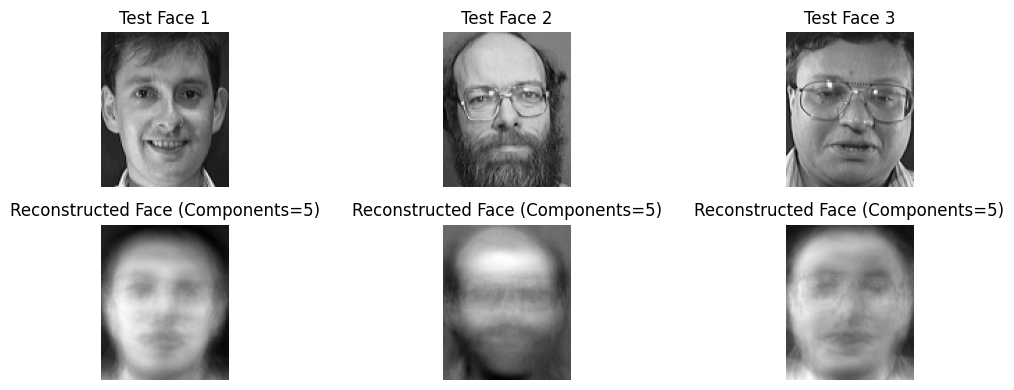

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (30,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (30,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (30,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (30,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (30,)
result shape (1, 10304)


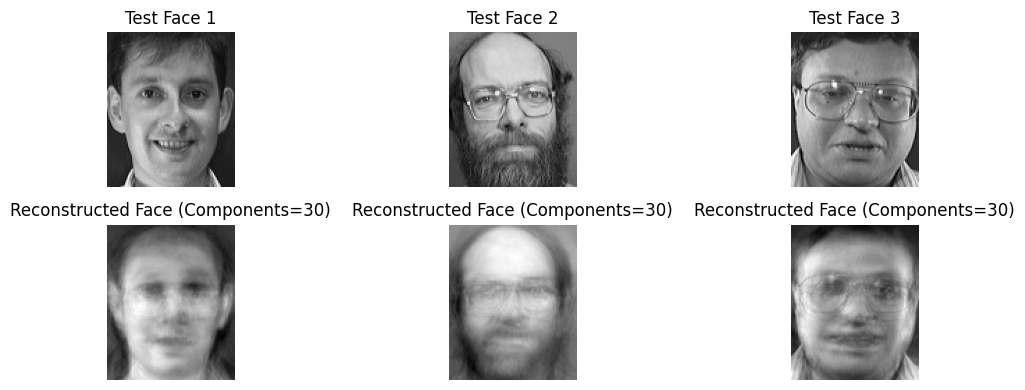

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (100,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (100,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (100,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (100,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (100,)
result shape (1, 10304)


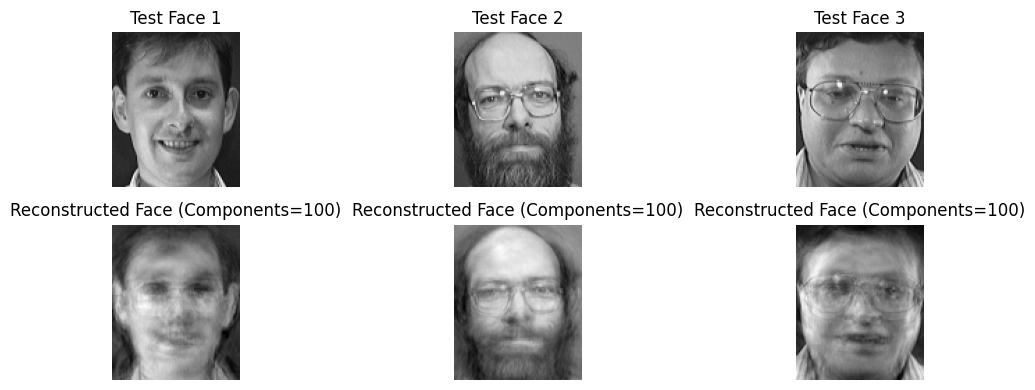

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (1000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (1000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (1000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (1000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (1000,)
result shape (1, 10304)


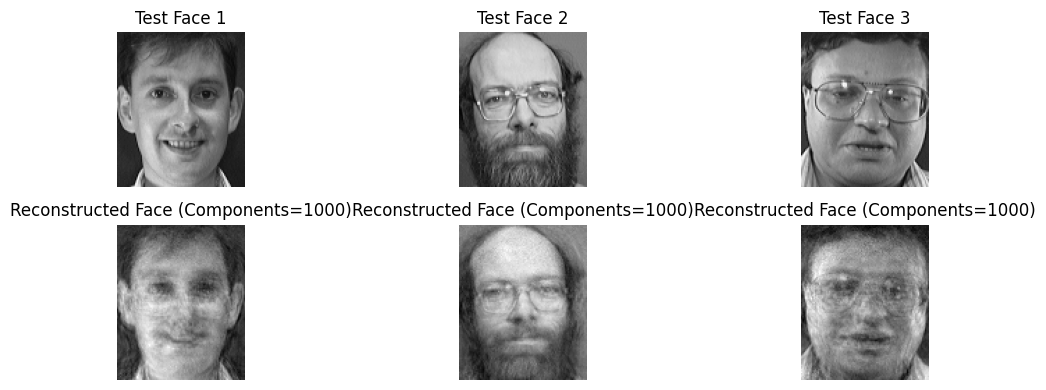

flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3000,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3000,)
result shape (1, 10304)


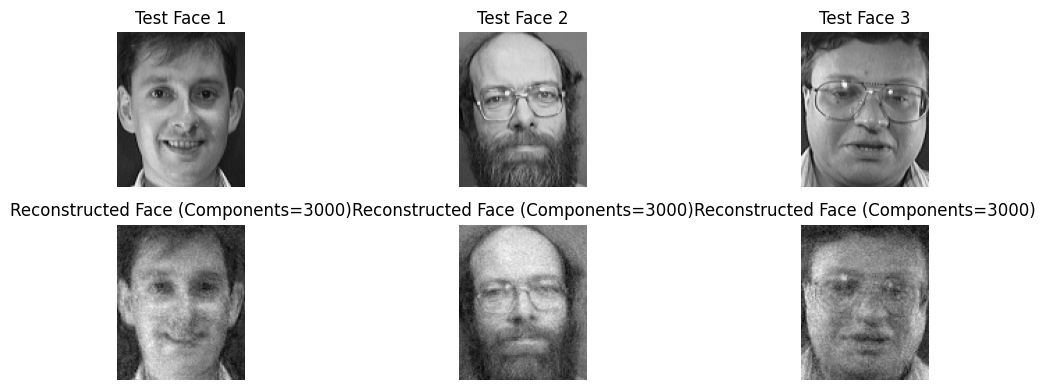

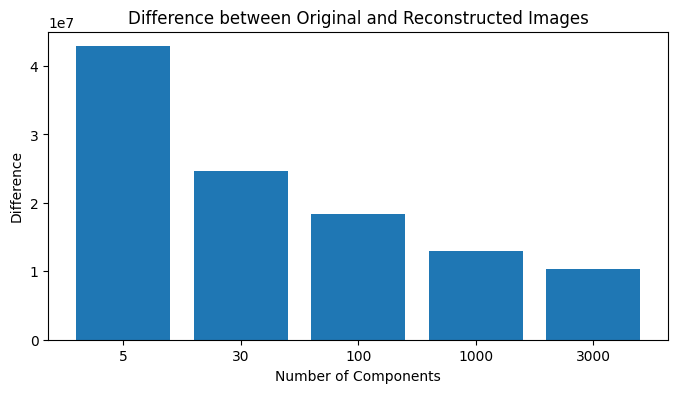

In [86]:
num_components_list = [5, 30, 100, 1000, 3000]
# send only 3 test faces for visulization
test_faces1 = testFaces[:5]
test_labels1 = testLabels[:5]
displayNfactors(test_faces1, eigen_faces, mean_face,weights,trainLabels, test_labels1, num_components_list)

#### Implement face recognition module based on the norm
Explain your steps with comments and write a brief explanation of the method.

*   Test the module and report accuracies based on the number of components taken for a range of value and plot them. 
*   Also plot the mean square error vs the number of eigenvectors taken and report your observations. 
*   For further empirical analysis, plot the semi-log variant of the error plot obtained above.

In [107]:
def getClass(test_image, eigen_vectors, mean_image, weights):
    """
    Arguments:
    1. Test image
    2. Eigenvectors
    3. Mean Eigen Face
    4. Training Set(X_train,y_train)

    The function must return the following:
    1. image with smallest error
    2. error value
    3. prediction class
  """   
    # STEP 1 : flatten the test face
    flattened_testFace = test_image.flatten()

    # STEP 2 SUBTRACT THE MEAN FACE
    zero_mean_testFace = flattened_testFace - mean_image

    # STEP 3 : COMPUTE WEIGHTS
    w = np.dot(zero_mean_testFace, eigen_vectors)
    print("weights shape",weight.shape)

    # Find which image is it closest to using minimum difference of weights
    min_error = float('inf')
    min_error_image = None
    min_error_label = None
    
    for i in range(360):
        error = np.linalg.norm(weights[i] - w)
        if error < min_error:
            min_error = error
            min_error_image =i
            min_error_label = trainLabels[i]
    
    return min_error_image, min_error, min_error_label

In [108]:
print(weights.shape)
print(trainFaces.shape)
print(testFaces.shape)

(360, 50)
(360, 112, 92)
(40, 112, 92)


weights shape (50,)
min_error_image 212
min_error 1086.6048253694457
min_error_label 6
actual label 6


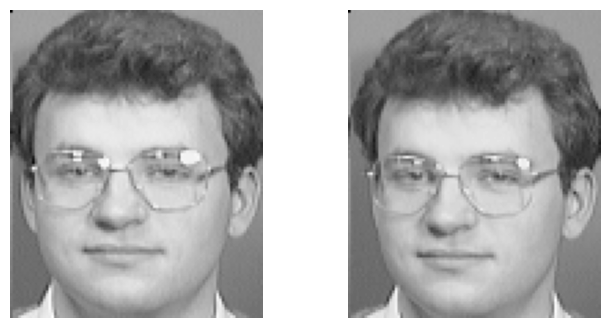

In [110]:
eigen_faces5=eigen_faces[:, :numComponents]
i=30
min_error_image, min_error, min_error_label = getClass(testFaces[30], eigen_faces5, mean_face, weights)
print("min_error_image",min_error_image)
print("min_error",min_error)
print("min_error_label",min_error_label)
print("actual label",testLabels[30])

# print thre min_error_image and actual image parallely in row
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(trainFaces[min_error_image], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(testFaces[30], cmap='gray')
plt.axis('off')
plt.show()

Iterate through all the images in the test data and test the accuracy by taking different number of components

In [105]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined the accuracy function and other necessary functions

components = [3, 5, 10, 20, 30, 40, 50]
mse = []
accuracyy = []
log_mse_dict = {}

for numComponents in components:
    # Call the accuracy function
    eigen_faces_6 = eigen_faces[:, :numComponents]
    weights = weights_train(zero_mean_faces, eigen_faces_6, mean_face, numComponents)
    acc, dict = accuracy(testFaces, eigen_faces_6, mean_face, weights, trainLabels, testLabels, numComponents)

    # Store accuracy and mean squared error
    accuracyy.append(acc)
    mse_value = np.sum(list(dict.values()))
    mse.append(mse_value)

    # Calculate and store log Mean Square Error
    log_mse = np.log(mse_value)  # Using natural logarithm
    log_mse_dict[numComponents] = log_mse




weights shape (360, 3)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
result shape (1, 10304)
flattened_testFace shape (10304,)
zero_mean_testFace shape (10304,)
weights shape (3,)
re

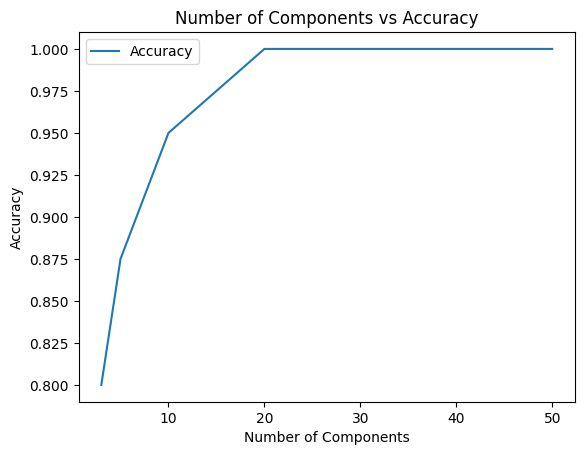

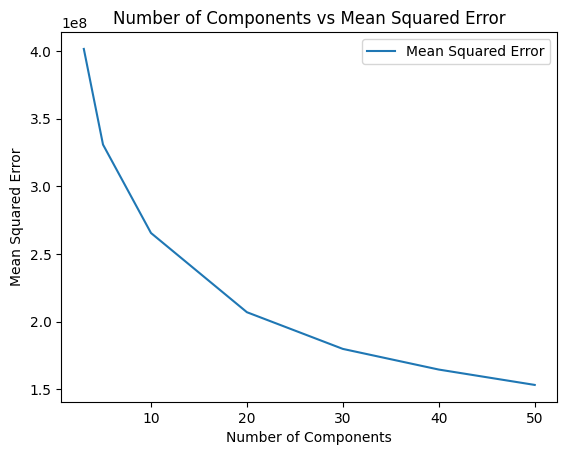

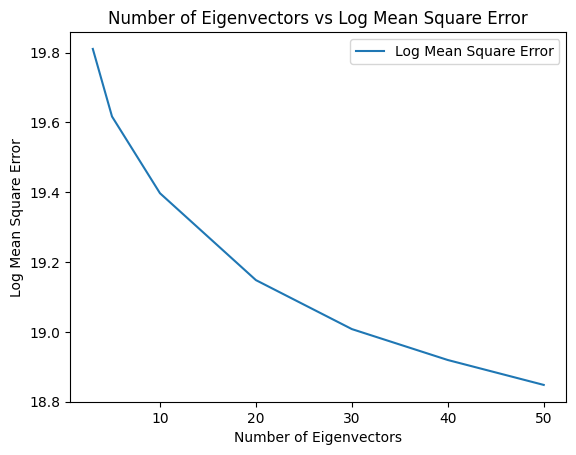

In [106]:
# Plot the results
import matplotlib.pyplot as plt

plt.plot(components, accuracyy, label='Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Number of Components vs Accuracy')
plt.legend()
plt.show()

plt.plot(components, mse, label='Mean Squared Error')
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.title('Number of Components vs Mean Squared Error')
plt.legend()
plt.show()

# Plot the results
plt.plot(components, log_mse_dict.values(), label='Log Mean Square Error')
plt.xlabel('Number of Eigenvectors')
plt.ylabel('Log Mean Square Error')
plt.title('Number of Eigenvectors vs Log Mean Square Error')
plt.legend()
plt.show()